In [1]:
import torch
torch.__version__

'2.3.0+cu121'

In [2]:
import os#
os.chdir('/home/mohammed/Work/STK_search')
#os.chdir("/rds/general/user/ma11115/home/STK_Search/STK_search")
from pathlib import Path#

import pandas as pd
import torch


import numpy as np
from stk_search.utils.config_utils import read_config, save_config
from stk_search.utils import update_datasets
import importlib
importlib.reload(update_datasets)
os.makedirs('data/output/search_experiment/search_exp_database', exist_ok=True)

In [3]:
# load Search space and check conditions
import pickle
search_space_loc = "data/input/STK_search_space/search_space_test.pkl"

save_dir = 'data/input/STK_search_space'
id = 'test'
SP = pickle.load(open(save_dir+f'/search_space_{id}.pkl', 'rb'))
SP.update()
print(SP.syntax)
print(SP.conditions_list)
print(f"size of the search space is : {SP.get_space_size():.2e}")
SP.df_precursors.head()

[0, 1, 2, 3, 4, 5]
[[], [], [], [], [], []]
size of the search space is : 1.86e+14


,InChIKey,Atom_num,HOMO (eV),LUMO (eV),HOMO_LUMO_GAP (eV),IP (eV),EA (eV),total energy (eV) vipea,First excited state Energy (eV),First excited osc,...,pca8,pca9,mol_opt_smiles,mol_org,mol_org_smile,ECFP,num_atoms,num_rings,cluster,orgcluster
0,KYORXLIHDAZXPK-UHFFFAOYSA-N,25,-11.5745,-10.1316,1.442883,7.1531,3.8935,-1699.611759,"[2.97, 3.437, 3.827, 3.901, 4.181]","[0.1323, 0.3332, 0.001, 0.4911, 0.5211]",...,-0.561829,1.909060,<rdkit.Chem.rdchem.Mol object at 0x72195f6813b0>,<rdkit.Chem.rdchem.Mol object at 0x72195f537a90>,C=C1C(=O)c2c(sc3ccccc23)C1=C(C#N)C#N,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, ...",25.0,3.0,0,0
2,UVCFYBOLMFIWGF-FPYGCLRLSA-N,22,-11.6536,-9.8300,1.823610,7.5190,4.1701,-1426.075709,"[3.543, 3.828, 3.987, 4.107, 4.23]","[0.0026, 0.1704, 0.206, 0.2256, 0.0395]",...,3.484916,0.540030,<rdkit.Chem.rdchem.Mol object at 0x72195f681e50>,<rdkit.Chem.rdchem.Mol object at 0x72195f537ae0>,[H]/C=C1\C(=O)c2c(F)cccc2C1=C(C#N)C#N,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...",22.0,2.0,0,2
3,PQZAHLJJGPAGBD-OQFOIZHKSA-N,22,-11.5774,-9.8714,1.706007,7.5324,4.1806,-1426.205720,"[3.779, 3.813, 4.035, 4.115, 4.429]","[0.0002, 0.0277, 0.1648, 0.3408, 0.0013]",...,8.579813,1.014201,<rdkit.Chem.rdchem.Mol object at 0x72195f681ea0>,<rdkit.Chem.rdchem.Mol object at 0x72195f537b30>,[H]/C=C1\C(=O)c2ccc(F)cc2C1=C(C#N)C#N,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...",22.0,2.0,0,3
4,HFUBKQHDPJZQIW-UHFFFAOYSA-N,13,-11.6185,-9.5986,2.019861,7.7105,3.7821,-1085.337355,"[4.436, 4.438, 5.127, 5.751, 5.826]","[0.2419, 0.2902, 0.0, 0.0, 0.0098]",...,2.916314,1.085874,<rdkit.Chem.rdchem.Mol object at 0x72195f681ef0>,<rdkit.Chem.rdchem.Mol object at 0x72195f537b80>,Fc1cc2c(cc1F)N=S=N2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, ...",13.0,2.0,1,4
5,XORWEKRDQCXPID-UHFFFAOYSA-N,28,-11.3061,-9.1919,2.114258,7.1941,3.5724,-1474.375137,"[3.81, 3.855, 4.251, 4.645, 4.799]","[0.1441, 0.2486, 0.0869, 0.0024, 0.0025]",...,3.638328,0.097783,<rdkit.Chem.rdchem.Mol object at 0x72195f681f40>,<rdkit.Chem.rdchem.Mol object at 0x72195f537bd0>,CCN1C(=O)c2cccc3cccc(c23)C1=O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",28.0,3.0,1,5


In [6]:
from stk_search.Objective_function import  Look_up_table
df_total_path = "data/Full_dataset/New_target07072024.csv"
df_total = pd.read_csv(df_total_path)
oligomer_size = 6
target_name = 'target'
aim = 'maximise'
df_total['target'] = (
        -np.abs(df_total["ES1"] - 3)
        - np.abs(df_total["ionisation potential (eV)"] - 5.5)
        + np.log10(df_total["fosc1"])
    )
df_total.to_csv(df_total_path, index=False)
# define the evaluation function
objective_function = Look_up_table(
            df_total, oligomer_size, target_name=target_name, aim=aim
        )

In [ ]:
# test evaluation function
molecule_id = 0
molecule_properties = SP.check_df_for_element_from_SP(df_total).iloc[[molecule_id]]
print(molecule_properties['InChIKey'])
molecule_properties[[f'InChIKey_{x}' for x in range(oligomer_size)]]
objective_function.evaluate_element(molecule_properties[[f'InChIKey_{x}' for x in range(oligomer_size)]])

0    AAAIKLIUXQWZQC-SBRRWJCQSA-N
Name: InChIKey, dtype: object


(-3.0251355934769806, 'AAAIKLIUXQWZQC-SBRRWJCQSA-N')

In [501]:
# initialise search algorithm 
from stk_search.Search_algorithm import BayesianOptimisation
from stk_search.Search_algorithm import Ea_surrogate

from stk_search.Search_algorithm.Search_algorithm import evolution_algorithm
from stk_search.Search_algorithm import Search_algorithm
importlib.reload(Search_algorithm)
importlib.reload(Ea_surrogate)
which_acquisition = 'EI'
lim_counter = 10
BO = BayesianOptimisation.BayesianOptimisation(which_acquisition=which_acquisition, lim_counter=lim_counter)
EA = Search_algorithm.evolution_algorithm()
SUEA = Ea_surrogate.Ea_surrogate()

In [502]:
# load the representation and the model 
from stk_search.Search_algorithm import Ea_surrogate

from stk_search.Representation import  Representation_poly_3d
import importlib
importlib.reload(Representation_poly_3d)
from stk_search.geom3d import pl_model
import torch.nn.functional as Functional
from stk_search.geom3d import train_models
from stk_search.Representation import  Representation_poly_3d

import importlib
importlib.reload(Representation_poly_3d)
importlib.reload(Ea_surrogate)


def load_representation_model(config_dir):
    config = read_config(config_dir)
    chkpt_path = config["model_embedding_chkpt"]
    checkpoint = torch.load(chkpt_path, map_location=config["device"])
    model, graph_pred_linear = pl_model.model_setup(config)
    print("Model loaded: ", config["model_name"])
    # Pass the model and graph_pred_linear to the Pymodel constructor
    pymodel = pl_model.Pymodel_new(model, graph_pred_linear, config)
    # Load the state dictionary
    pymodel.load_state_dict(state_dict=checkpoint["state_dict"])
    #pymodel.load_state_dict(state_dict=checkpoint["state_dict"])
    pymodel.to(config["device"])
    representation = Representation_poly_3d.Representation_poly_3d(pymodel,
                                                                   mongo_client=config['pymongo_client'],
                                                                   database=config['database_name'],
                                                                   device = pymodel.device)

    return representation, pymodel
#config_dir = "/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240430/SchNet/splitrand-nummol68864/Emb_dim_12"
config_dir = "data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol5000/"
config, min_val_loss = train_models.get_best_embedding_model(config_dir)

Representation, pymodel = load_representation_model(config_dir)

SUEA = Ea_surrogate.Ea_surrogate()
SUEA.pred_model = pymodel.graph_pred_linear
SUEA.Representation = Representation

config loaded from data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol5000/
data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol5000/epoch=6-val_loss=0.25-other_metric=0.00.ckpt
config loaded from data/representation_learning//6-frag/target/240726//SchNet/splitrand-nummol5000/
Model loaded:  SchNet


In [503]:
# initialise the representation of the molecules used
# here we use the dataframe of the precursors that has PCA of desrciprtors calculated using mordred
from stk_search.Representation import (
    Representation_from_fragment,
    Representation_3d_from_fragment,
)

df_representation_path = "data/Prescursor_data/df_mordred_10072024.pkl"
df_representation = pd.read_pickle(df_representation_path)
df_representation.dropna(axis=1, inplace=True)
# check if the representation dataframe contains all the elements in teh search space
print(
    "number of element not in the representation dataframe ",
    -(SP.df_precursors["InChIKey"].isin(df_representation["InChIKey"]).sum()
    - SP.df_precursors.shape[0]),
)
if -(SP.df_precursors["InChIKey"].isin(df_representation["InChIKey"]).sum() - SP.df_precursors.shape[0]) > 0:
    SP.df_precursors = SP.df_precursors[SP.df_precursors["InChIKey"].isin(df_representation["InChIKey"])]
    with open(search_space_loc, "wb") as f:
        pickle.dump(SP, f)
frag_properties = df_representation.select_dtypes(include=[np.number]).columns
print(frag_properties)
BO.Representation = Representation_from_fragment.Representation_from_fragment(
    df_representation, frag_properties
)
search_algorithm = BO

number of element not in the representation dataframe  0
Index(['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7',
       'PCA_8', 'PCA_9'],
      dtype='object')


In [504]:
# test representation
search_algorithm = SUEA
molecule_id = 0
molecule_properties = SP.check_df_for_element_from_SP(df_total).iloc[[molecule_id]]
print(molecule_properties['InChIKey'])
molecule_properties[[f'InChIKey_{x}' for x in range(oligomer_size)]]
X_rpr = SUEA.Representation.generate_repr(molecule_properties[[f'InChIKey_{x}' for x in range(oligomer_size)]])
SUEA.pred_model(X_rpr)

1    AAALPPGKJQYWNO-NOPDUFPGSA-N
Name: InChIKey, dtype: object


Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[-1.5594]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [505]:
from stk_search import SearchExp
importlib.reload(SearchExp)
# set experiment conditions
num_elem_initialisation=50
num_iteration=20
number_of_iterations = num_iteration
verbose = True
S_exp = SearchExp.SearchExp(
        SP,
        search_algorithm,
        objective_function,
        number_of_iterations,
        verbose=verbose,
    )
test_name = 'test'
benchmark  = True
S_exp.output_folder = (
        f"data/output/search_experiment/{oligomer_size}_frag/" + test_name
    )
S_exp.num_elem_initialisation = num_elem_initialisation
S_exp.benchmark = benchmark
S_exp.df_total = df_total


In [506]:
# Save search inputs
import json
import subprocess
def save_run_search_inputs(inputs, save_path="run_search_new_inputs.json"):
    # Get the current git version
    git_version = (
        subprocess.check_output(["git", "rev-parse", "HEAD"])
        .strip()
        .decode("utf-8")
    )

    # Add the git version to the inputs
    inputs["git_version"] = git_version

    # Save the inputs to a file
    with open(save_path, "w") as f:
        json.dump(inputs, f)

    print("Inputs saved.")
input_json ={}
input_json["search_space_loc"] = search_space_loc
input_json["search_algorithm"] = search_algorithm.__str__()
input_json["objective_function"] = objective_function.__str__()
input_json["number_of_iterations"] = number_of_iterations
input_json["verbose"] = verbose
input_json["num_elem_initialisation"] = num_elem_initialisation
input_json["benchmark"] = benchmark
input_json["df_total"] = df_total_path
input_json["df_representation"] = df_representation_path
input_json["frag_properties"] = list(frag_properties)
input_json["run_search_name"] = S_exp.search_exp_name
input_json["search_output_folder"] = S_exp.output_folder
input_json["date"] = S_exp.date
save_path = f"data/output/search_experiment/search_exp_database/{S_exp.search_exp_name}.json"
save_run_search_inputs(input_json, save_path)

Inputs saved.


In [508]:
S_exp.number_of_iterations = 20
S_exp.run_seach()
max(S_exp.ids_acquired)

Pandas Apply:   0%|          | 0/254 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/24 [00:00<?, ?it/s]

new_element_df shape is  (254, 6)
8
element Inchikey suggested: YSTULWMZUVXJSU-UHFFFAOYSA-N, Eval: 0.1490586684040217
iteration 2 completed
max fitness acquired: 0.4208780539996415
min fitness acquired: -4.0088507096021
new fitness acquired: 0.1490586684040217


Pandas Apply:   0%|          | 0/315 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/74 [00:00<?, ?it/s]

new_element_df shape is  (315, 6)
10
element Inchikey suggested: YLRPSUOYUMTNBD-UHFFFAOYSA-N, Eval: 0.23750419026700276
iteration 3 completed
max fitness acquired: 0.4208780539996415
min fitness acquired: -4.0088507096021
new fitness acquired: 0.23750419026700276


Pandas Apply:   0%|          | 0/248 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

new_element_df shape is  (248, 6)
1
element Inchikey suggested: WNXBSEZQZLGYQM-UHFFFAOYSA-N, Eval: 0.33516641008086645
iteration 4 completed
max fitness acquired: 0.4208780539996415
min fitness acquired: -4.0088507096021
new fitness acquired: 0.33516641008086645


Pandas Apply:   0%|          | 0/195 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13 [00:00<?, ?it/s]

new_element_df shape is  (195, 6)
0
element Inchikey suggested: IHFGWFKTEORVKD-UHFFFAOYSA-N, Eval: 0.42389297883768984
iteration 5 completed
max fitness acquired: 0.42389297883768984
min fitness acquired: -4.0088507096021
new fitness acquired: 0.42389297883768984


Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

new_element_df shape is  (192, 6)
90
element Inchikey suggested: OYULXVZYMCQQBY-UHFFFAOYSA-N, Eval: 0.3449882585824723
iteration 6 completed
max fitness acquired: 0.42389297883768984
min fitness acquired: -4.0088507096021
new fitness acquired: 0.3449882585824723


Pandas Apply:   0%|          | 0/245 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

new_element_df shape is  (245, 6)
155
element Inchikey suggested: FNFZBSIYXLPFPR-UHFFFAOYSA-N, Eval: 0.3316021537533771
iteration 7 completed
max fitness acquired: 0.42389297883768984
min fitness acquired: -4.0088507096021
new fitness acquired: 0.3316021537533771


Pandas Apply:   0%|          | 0/201 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

new_element_df shape is  (201, 6)
105
element Inchikey suggested: CXFXEBDOLQTIFB-UHFFFAOYSA-N, Eval: 0.38926795022858807
iteration 8 completed
max fitness acquired: 0.42389297883768984
min fitness acquired: -4.0088507096021
new fitness acquired: 0.38926795022858807


Pandas Apply:   0%|          | 0/210 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/22 [00:00<?, ?it/s]

new_element_df shape is  (210, 6)
8
element Inchikey suggested: XQGPRKAQEHJIOJ-UHFFFAOYSA-N, Eval: 0.20689057908396147
iteration 9 completed
max fitness acquired: 0.42389297883768984
min fitness acquired: -4.0088507096021
new fitness acquired: 0.20689057908396147


Pandas Apply:   0%|          | 0/220 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

new_element_df shape is  (220, 6)
128
element Inchikey suggested: VMOPODPISKOHBR-UHFFFAOYSA-N, Eval: 0.3706244304809192
iteration 10 completed
max fitness acquired: 0.42389297883768984
min fitness acquired: -4.0088507096021
new fitness acquired: 0.3706244304809192


Pandas Apply:   0%|          | 0/204 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

new_element_df shape is  (204, 6)
11
element Inchikey suggested: UKZNLVDJFFICNG-UHFFFAOYSA-N, Eval: 0.2714632732621335
iteration 11 completed
max fitness acquired: 0.42389297883768984
min fitness acquired: -4.0088507096021
new fitness acquired: 0.2714632732621335


Pandas Apply:   0%|          | 0/485 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/125 [00:00<?, ?it/s]

new_element_df shape is  (485, 6)
249
element Inchikey suggested: YGSQPUUJRVWOST-UHFFFAOYSA-N, Eval: 0.4345011971439803
iteration 12 completed
max fitness acquired: 0.4345011971439803
min fitness acquired: -4.0088507096021
new fitness acquired: 0.4345011971439803


Pandas Apply:   0%|          | 0/200 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13 [00:00<?, ?it/s]

new_element_df shape is  (200, 6)
104
element Inchikey suggested: APARULWZWGTZOB-UHFFFAOYSA-N, Eval: 0.44856826761435153
iteration 13 completed
max fitness acquired: 0.44856826761435153
min fitness acquired: -4.0088507096021
new fitness acquired: 0.44856826761435153


Pandas Apply:   0%|          | 0/152 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

new_element_df shape is  (152, 6)
142
element Inchikey suggested: WTVHZZSETLLXOV-UHFFFAOYSA-N, Eval: 0.2699205314617007
iteration 14 completed
max fitness acquired: 0.44856826761435153
min fitness acquired: -4.0088507096021
new fitness acquired: 0.2699205314617007


Pandas Apply:   0%|          | 0/140 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

new_element_df shape is  (140, 6)
23
element Inchikey suggested: IXDYSYCIMMQVHD-UHFFFAOYSA-N, Eval: 0.41928048676834984
iteration 15 completed
max fitness acquired: 0.44856826761435153
min fitness acquired: -4.0088507096021
new fitness acquired: 0.41928048676834984


Pandas Apply:   0%|          | 0/237 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

new_element_df shape is  (237, 6)
90
element Inchikey suggested: LFIYWSBCCYHFHZ-UHFFFAOYSA-N, Eval: 0.4048851453035992
iteration 16 completed
max fitness acquired: 0.44856826761435153
min fitness acquired: -4.0088507096021
new fitness acquired: 0.4048851453035992


Pandas Apply:   0%|          | 0/144 [00:00<?, ?it/s]

new_element_df shape is  (144, 6)
8
element Inchikey suggested: JPISIEJJBTVTRM-UHFFFAOYSA-N, Eval: 0.4243578706890051
iteration 17 completed
max fitness acquired: 0.44856826761435153
min fitness acquired: -4.0088507096021
new fitness acquired: 0.4243578706890051


Pandas Apply:   0%|          | 0/236 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

new_element_df shape is  (236, 6)
3
element Inchikey suggested: CHCBZIPVRCCVSG-UHFFFAOYSA-N, Eval: 0.35651736414919055
iteration 18 completed
max fitness acquired: 0.44856826761435153
min fitness acquired: -4.0088507096021
new fitness acquired: 0.35651736414919055


Pandas Apply:   0%|          | 0/202 [00:00<?, ?it/s]

new_element_df shape is  (202, 6)
8
element Inchikey suggested: FHZAOSLVHLXTKK-UHFFFAOYSA-N, Eval: 0.44716942403753723
iteration 19 completed
max fitness acquired: 0.44856826761435153
min fitness acquired: -4.0088507096021
new fitness acquired: 0.44716942403753723


69

## using a helper function 

In [ ]:
# run a search experiment with the new target
from stk_search.utils import run_hpc_utils
importlib.reload(run_hpc_utils)
case_name = 'BO_precursor'#'BO_learned'
df_total_path = "data/Full_dataset/New_target07072024.csv"
df_representation_path ="data/Prescursor_data/df_frag_xtb_properties.pkl"
exp_name = "new_target"
search_space_loc = "data/input/STK_search_space/search_space_test.pkl"
which_acquisition = "EI"

string_to_run_notbook, script_qsub = run_hpc_utils.generate_string_run(
                case=case_name,
                target="target",
                aim='maximise',
                num_elem_initialisation=50,
                num_iteration=20,
                df_path=df_total_path,
                benchmark=True,
                test_name= exp_name,
                df_representation_path=df_representation_path,
                frag_properties="selected",
                search_space_loc = search_space_loc,
                which_acquisition = which_acquisition,
            )

%run $string_to_run_notbook

src/dev_scripts/run_search_new.py  --case BO_precursor --test_name new_target --target target --aim maximise --benchmark 1 --num_iteration 20 --num_elem_initialisation 50 --which_acquisition EI --df_path data/Full_dataset/New_target07072024.csv --df_representation_path data/Prescursor_data/df_frag_xtb_properties.pkl --config_dir /rds/general/user/ma11115/home/Geom3D/Geom3D/training/SchNet_frag/ --search_space_loc data/input/STK_search_space/search_space_test.pkl --frag_properties selected --lim_counter 10 --budget None
 number of fragment 6
True benchmark
BO_precursor   case  
Index(['Atom_num', 'HOMO (eV)', 'LUMO (eV)', 'HOMO_LUMO_GAP (eV)', 'IP (eV)',
       'EA (eV)', '1 Excited state Energy (eV)', '1 Excited state Osc',
       '2 Excited state Energy (eV)', '2 Excited state Osc',
       '3 Excited state Energy (eV)', '3 Excited state Osc'],
      dtype='object')
Inputs saved.
element Inchikey suggested: WARFJUQWCHFUIX-UHFFFAOYSA-N, Eval: -0.0030399532609941
element Inchikey suggest

/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: DEEBTDJJZMKPQQ-UHFFFAOYSA-N, Eval: 0.4023549853613808
iteration 0 completed
max fitness acquired: 0.6589781617095453
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.4023549853613808


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: UKVVVCVRGSNIFX-ORHMFCTNSA-N, Eval: -2.407596282854981
iteration 1 completed
max fitness acquired: 0.6589781617095453
min fitness acquired: -2.8613581119380456
new fitness acquired: -2.407596282854981


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: MJWZFBKLZXLQBM-UHFFFAOYSA-N, Eval: 0.4710826574169969
iteration 2 completed
max fitness acquired: 0.6589781617095453
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.4710826574169969


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: CEDNFFLRZZAMEX-UHFFFAOYSA-N, Eval: 0.2990013202236261
iteration 3 completed
max fitness acquired: 0.6589781617095453
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.2990013202236261


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: IXEPVESFDOXXFS-UHFFFAOYSA-N, Eval: 0.0526158638380358
iteration 4 completed
max fitness acquired: 0.6589781617095453
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.0526158638380358


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: BGNCEKURCLOXJV-UHFFFAOYSA-N, Eval: 0.2196208031023794
iteration 5 completed
max fitness acquired: 0.6589781617095453
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.2196208031023794


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: UNIQXRNZORAFPW-UHFFFAOYSA-N, Eval: 0.5024778211842527
iteration 6 completed
max fitness acquired: 0.6589781617095453
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.5024778211842527


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: YFORXFQPOTZBFV-UHFFFAOYSA-N, Eval: 0.6677766987131148
iteration 7 completed
max fitness acquired: 0.6677766987131148
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.6677766987131148


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: JPKAFMFBWIWFEI-UHFFFAOYSA-N, Eval: 0.2214258941461603
iteration 8 completed
max fitness acquired: 0.6677766987131148
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.2214258941461603


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: RVVYZWXSKLTACG-UHFFFAOYSA-N, Eval: 0.249124296268494
iteration 9 completed
max fitness acquired: 0.6677766987131148
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.249124296268494


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: PVRKMRYNHHQJBX-UHFFFAOYSA-N, Eval: 0.553051889575322
iteration 10 completed
max fitness acquired: 0.6677766987131148
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.553051889575322


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: FWHXBOIBEZKHMO-UXXSKLMQSA-N, Eval: 0.05822463580843
iteration 11 completed
max fitness acquired: 0.6677766987131148
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.05822463580843


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: XWDXZFWKYFELNS-UHFFFAOYSA-N, Eval: 0.2844264488462291
iteration 12 completed
max fitness acquired: 0.6677766987131148
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.2844264488462291


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: TVGMXVVDUNVBQI-UHFFFAOYSA-N, Eval: 0.3377799030214551
iteration 13 completed
max fitness acquired: 0.6677766987131148
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.3377799030214551


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: QHFQCJHYRYXITI-UHFFFAOYSA-N, Eval: 0.3810705909141993
iteration 14 completed
max fitness acquired: 0.6677766987131148
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.3810705909141993


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: LAOHNOPMKGBAHY-DNWAADLDSA-N, Eval: 0.1817219247658326
iteration 15 completed
max fitness acquired: 0.6677766987131148
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.1817219247658326


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: JTTRIYKVBCXYFU-UHFFFAOYSA-N, Eval: -0.3544995543982658
iteration 16 completed
max fitness acquired: 0.6677766987131148
min fitness acquired: -2.8613581119380456
new fitness acquired: -0.3544995543982658


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strong

element Inchikey suggested: KKIPBRMYIUVZOE-UHFFFAOYSA-N, Eval: 0.3399877948680103
iteration 17 completed
max fitness acquired: 0.6677766987131148
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.3399877948680103


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: FNWLBIJJEBBVSO-KOZRTQQMSA-N, Eval: -0.1911075691596437
iteration 18 completed
max fitness acquired: 0.6677766987131148
min fitness acquired: -2.8613581119380456
new fitness acquired: -0.1911075691596437


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3

element Inchikey suggested: BJWXPILEORCZHM-UHFFFAOYSA-N, Eval: 0.6243889369486562
iteration 19 completed
max fitness acquired: 0.6677766987131148
min fitness acquired: -2.8613581119380456
new fitness acquired: 0.6243889369486562


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


# load results and plot some metrics

In [ ]:

import glob
import pickle
import json
def load_search_list(df):
    search_list = []
    for index, row in df.iterrows():
        search_list.append(pickle.load(open(row['search_exp_file'], "rb")))
    return search_list
save_path = f"data/output/search_experiment/search_exp_database"
json_files = glob.glob(f"{save_path}/*.json")
list_json = []
for json_file in json_files:
    try:
        with open(json_file, 'r') as f:
            list_json.append(json.load(f))
        f.close()
    except: 
        print('error oppening',json_file)
df = pd.DataFrame(list_json)
df['search_exp_file'] = df['search_output_folder']+"/"+df['date']+"/results_"+df['run_search_name']+'.pkl'
#df = df[~df['benchmark']]
print(df.shape)
df_all = df.copy()
df_all.head()


(6, 28)


,search_space_loc,search_algorithm,objective_function,number_of_iterations,verbose,num_elem_initialisation,benchmark,df_total,df_representation,frag_properties,...,config_dir,aim,which_acquisition,lim_counter,oligomer_size,df_path,df_representation_path,dataset_representation_path,budget,search_exp_file
0,data/input/STK_search_space/search_space_test.pkl,<stk_search.Search_algorithm.BayesianOptimisat...,<stk_search.Objective_function.Look_up_table o...,2.0,True,50,True,data/Full_dataset/New_target07072024.csv,data/Prescursor_data/df_mordred_10072024.pkl,"[PCA_0, PCA_1, PCA_2, PCA_3, PCA_4, PCA_5, PCA...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data/output/search_experiment/6_frag/test/2024...
1,data/input/STK_search_space/search_space_test.pkl,NaN,NaN,NaN,NaN,50,True,NaN,NaN,selected,...,/rds/general/user/ma11115/home/Geom3D/Geom3D/t...,maximise,EI,10.0,6.0,data/Full_dataset/New_target07072024.csv,data/Prescursor_data/df_frag_xtb_properties.pkl,,NaN,data/output/search_experiment/6_frag/new_targe...
2,data/input/STK_search_space/search_space_test.pkl,NaN,NaN,NaN,NaN,50,True,NaN,NaN,selected,...,/rds/general/user/ma11115/home/Geom3D/Geom3D/t...,maximise,EI,10.0,6.0,data/Full_dataset/New_target07072024.csv,data/Prescursor_data/df_frag_xtb_properties.pkl,,NaN,data/output/search_experiment/6_frag/new_targe...
3,data/input/STK_search_space/search_space_test.pkl,<stk_search.Search_algorithm.BayesianOptimisat...,<stk_search.Objective_function.Look_up_table o...,2.0,True,50,True,data/Full_dataset/New_target07072024.csv,data/Prescursor_data/precursor_data_mordred_de...,"[Atom_num, HOMO (eV), LUMO (eV), HOMO_LUMO_GAP...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data/output/search_experiment/6_frag/test/2024...
4,data/input/STK_search_space/search_space_test.pkl,NaN,NaN,NaN,NaN,50,True,NaN,NaN,selected,...,/rds/general/user/ma11115/home/Geom3D/Geom3D/t...,maximise,EI,10.0,6.0,data/Full_dataset/New_target07072024.csv,data/Prescursor_data/df_frag_xtb_properties.pkl,,NaN,data/output/search_experiment/6_frag/new_targe...


In [ ]:
num_iteration = 20
num_elem_initialisation = 50
oligomer_size = 6 
#df_filtered = df_all[df_all['num_iteration']==num_iteration]
#df_filtered = df_filtered[df_filtered['num_elem_initialisation']==num_elem_initialisation]
df_filtered = df_all[df_all['oligomer_size']==oligomer_size]
print(df_filtered.shape)
df_list = df_filtered.groupby(['case','frag_properties','which_acquisition','config_dir'])
print(len(df_list))
df_filtered.groupby(['case','frag_properties','which_acquisition','config_dir']).describe()

(4, 28)
1


number_of_iterations  \
                                                                                                                 count   
case         frag_properties which_acquisition config_dir                                                                
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr...                  0.0   

                                                                                                        \
                                                                                                  mean   
case         frag_properties which_acquisition config_dir                                                
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr...  NaN   

                                                                                                       \
                                                                                                  std   
case         frag_properties which_acquisition config_dir                                               
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr... NaN   

                                                                                                       \
                                                                                                  min   
case         frag_properties which_acquisition config_dir                                               
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr... NaN   

                                                                                                       \
                                                                                                  25%   
case         frag_properties which_acquisition config_dir                                               
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr... NaN   

                                                                                                       \
                                                                                                  50%   
case         frag_properties which_acquisition config_dir                                               
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr... NaN   

                                                                                                       \
                                                                                                  75%   
case         frag_properties which_acquisition config_dir                                               
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr... NaN   

                                                                                                       \
                                                                                                  max   
case         frag_properties which_acquisition config_dir                                               
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr... NaN   

                                                                                                  num_elem_initialisation  \
                                                                                                                    count   
case         frag_properties which_acquisition config_dir                                                                   
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr...                     4.0   

                                                                                                         \
                                                  

In [ ]:
import pandas as pd
def join_name(x):
    return '_'.join(x)

def load_search_list(df,min_num_iteration):
    search_list = []
    for index, row in df.iterrows():
        if min_num_iteration <= row['max_num_eval']:
            search_list.append(pd.read_pickle(row['search_exp_file']))
    return search_list
def get_results_length(x):
    try:
        return len(pd.read_pickle(x)['fitness_acquired'])
    except Exception as e:
        #print(e)
        return 0
results_dict = {}
num_searches_with_min, df_plot_dict = {}, {}
min_num_iteration = 70
for name , df in df_list:
    if len(df) != 0: 
        df['max_num_eval']=df['search_exp_file'].apply(lambda x: get_results_length(x))
        key = join_name(name)
        df['key'] = key
        if df['max_num_eval'].max() >= min_num_iteration:
            results_dict[key] = load_search_list(df,min_num_iteration)
            num_searches_with_min[key] = (len(results_dict[key]), df['df_path'].values[0])
df_summary_1 = pd.DataFrame.from_dict(num_searches_with_min, orient='index',columns=['number of explorations with min iterations','df_path'])
#df_summary = df_summary.merge(df_summary_1, left_index=True, right_index=True)
df_summary_1['key'] = df_summary_1.index    
df_summary_1['case'] = df_summary_1['key'].apply(lambda x: x.split('_')[0]+'_'+x.split('_')[1])
df_summary_1['num_mol_training'] = df_summary_1['key'].apply(lambda x: x.split('nummol')[-1])
df_summary_1['wide']=df_summary_1['key'].apply(lambda x: '_wide' in x)
df_summary_1['narrow']=df_summary_1['key'].apply(lambda x: '_narrow' in x)
df_summary_1['total']=df_summary_1['key'].apply(lambda x: '_total' in x)
df_summary_1.reset_index(inplace=True)
df_summary_1

,index,number of explorations with min iterations,df_path,key,case,num_mol_training,wide,narrow,total
0,BO_precursor_selected_EI_/rds/general/user/ma1...,1,data/Full_dataset/New_target07072024.csv,BO_precursor_selected_EI_/rds/general/user/ma1...,BO_precursor,BO_precursor_selected_EI_/rds/general/user/ma1...,False,False,False


In [ ]:
import datetime
import pickle
from stk_search.utils import Search_results_plot
from stk_search.utils import plot_results_all
import importlib
importlib.reload(Search_results_plot)
importlib.reload(plot_results_all)
save_folder = 'data/figures/'+datetime.datetime.now().strftime("_%Y_%m_%d")
plot_function_list_single = [Search_results_plot.plot_simple_regret,Search_results_plot.plot_inst_regret,Search_results_plot.plot_cumulative_regret,
                      Search_results_plot.plot_number_of_molecule_discovered,Search_results_plot.plot_rate_of_discovery,]
plot_function_list_multi = [Search_results_plot.plot_simple_regret_batch,Search_results_plot.plot_number_of_molecule_discovered_sum,Search_results_plot.plot_total_rate_of_discovery, ]

 keys : 0    BO_precursor_selected_EI_/rds/general/user/ma1...
Name: key, dtype: object


/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/mohammed/anaconda3/envs/stk_search/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


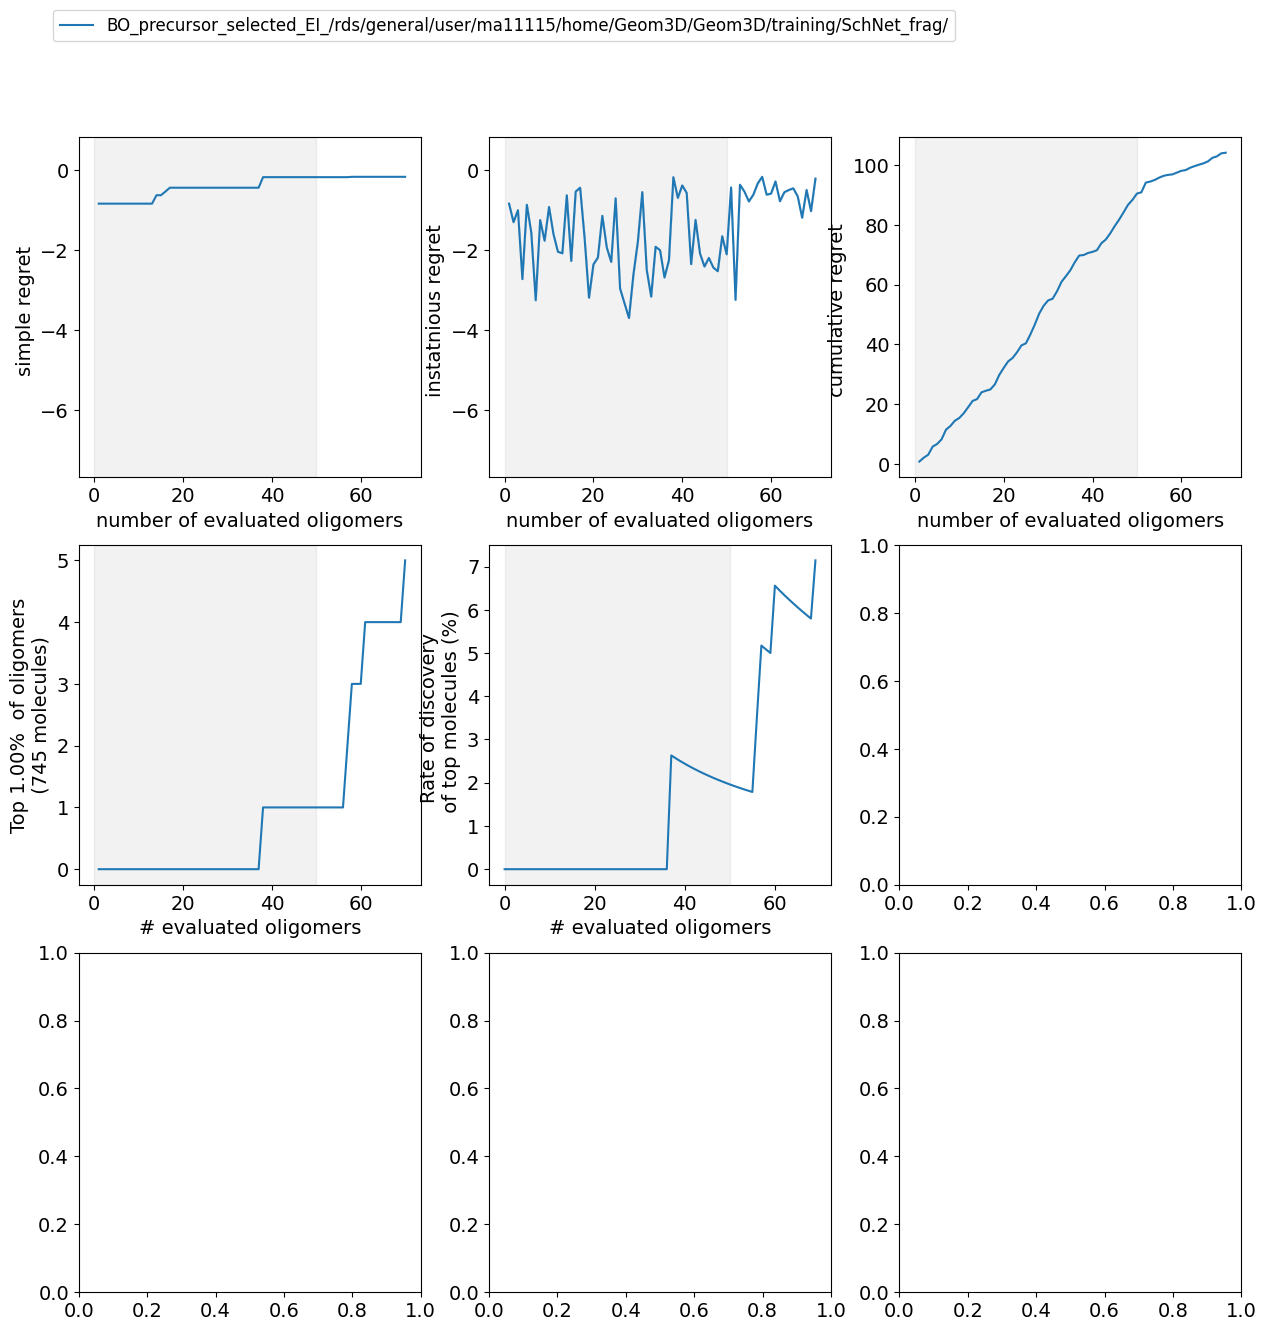

In [ ]:
%matplotlib inline
df_plot = df_summary_1.copy()
df_plot = df_plot.iloc[[0]]
fig, axes,metric_dict_res = plot_results_all.plot_metric(df_plot,plot_function_list_single,results_dict,df_list,nb_iterations=70)

